<h1>MassBalanceMachine XGBoost Model Training - Iceland Region Example</h1>
<p style='text-align: justify;'>
In this notebook, we will simulate the glacier surface mass balance for the Iceland region using a custom <a href='https://xgboost.readthedocs.io/en/stable/'>XGBoost</a> model. The XGBoost model is designed with a custom objective function that generates monthly predictions based on aggregated observational data. We will create an instance of <code>CustomXGBoostRegressor</code> and train it using this custom loss function on the stake data from Iceland, which we have prepared in earlier notebooks. If you haven't already, please review the <a href='https://github.com/ODINN-SciML/MassBalanceMachine/blob/main/notebooks/data_preprocessing.ipynb'>data preprocessing</a> and <a href='https://github.com/ODINN-SciML/MassBalanceMachine/blob/main/notebooks/data_preprocessing.ipynb'>data processing WGMS</a> notebooks for more details.</p>

<p style='text-align: justify;'>
The workflow includes several key steps:
</p>

<ol style="margin-left: 20px; padding-left: 0;">
    <li style="margin-bottom: 10px;">
        <p style='text-align: justify;'><strong>Data Loading and Preparation:</strong> A <code>Dataloader</code> object is created to handle the loading of data and the creation of a training and testing split. This object also manages the generation of data splits for cross-validation.</p>
    </li>
    <li style="margin-bottom: 10px;">
        <p style='text-align: justify;'><strong>Cross-Validation and Model Training:</strong> Using Scikit-learn's cross-validation techniques, we explore different hyperparameters and train the model on the prepared data splits. This approach ensures a robust evaluation and helps in selecting suitable parameters.</p>
    </li>
    <li style="margin-bottom: 10px;">
        <p style='text-align: justify;'><strong>Aggregated Predictions:</strong> After training, we will display the aggregated monthly predictions generated by the model to visualize and analyze the results.</p>
    </li>
    <li style="margin-bottom: 10px;">
        <p style='text-align: justify;'><strong>Model Evaluation:</strong> Finally, the model's performance is evaluated on the test set, providing insights into its predictive accuracy for glacier mass balance.</p>
    </li>
</ol>

In [141]:
import pandas as pd
import massbalancemachine as mbm
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
# Set a random seed:
SEED = 30

data = pd.read_csv('./example_data/svalbard/svalbard_monthly_dataset_era5.csv')
#data = pd.read_csv('./example_data/iceland/files/iceland_monthly_dataset.csv')
data["POINT_BALANCE"] = data["POINT_BALANCE"]/1000


#data = data.drop(columns = ["ELEVATION_DIFFERENCE","ALTITUDE_CLIMATE"])
data = data.drop(columns = ["ELEVATION_DIFFERENCE","aspect","slope","slhf","sshf","ssrd","fal","str"])

print('Number of samples:', len(data))

"""# scale the data
scaler = StandardScaler()
scaler.fit(data["POINT_BALANCE"].values.reshape(-1,1))
data["POINT_BALANCE"]=scaler.transform(data["POINT_BALANCE"].values.reshape(-1,1))"""

display(data)

Number of samples: 22433


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,RGIId,POINT_ID,ID,N_MONTHS,MONTHS,t2m,tp
0,1967,11.827670,78.904665,-1.61,82.090782,RGI60-07.00504,NaN,0,4,may,268.559351,0.001238
1,1967,11.827670,78.904665,-1.61,82.090782,RGI60-07.00504,NaN,0,4,jun,273.300042,0.001516
2,1967,11.827670,78.904665,-1.61,82.090782,RGI60-07.00504,NaN,0,4,jul,275.948803,0.001343
3,1967,11.827670,78.904665,-1.61,82.090782,RGI60-07.00504,NaN,0,4,aug,275.014967,0.003084
4,1967,11.827670,78.904665,-1.61,82.090782,RGI60-07.00504,NaN,0,4,sep,272.331492,0.003372
...,...,...,...,...,...,...,...,...,...,...,...,...
22428,2018,17.453729,78.811326,0.55,963.213711,RGI60-07.00570,NaN,3720,6,dec,262.739021,0.003992
22429,2018,17.453729,78.811326,0.55,963.213711,RGI60-07.00570,NaN,3720,6,jan,261.590647,0.002210
22430,2018,17.453729,78.811326,0.55,963.213711,RGI60-07.00570,NaN,3720,6,feb,261.209475,0.003056
22431,2018,17.453729,78.811326,0.55,963.213711,RGI60-07.00570,NaN,3720,6,mar,253.043794,0.001112


<h2>1. Create the Train and Test Dataset and the Data Splits for Cross Validation</h2>
<p style='text-align: justify;'>
First, we create a <code>DataLoader</code> object, which generates both training and testing datasets, as well as the data splits required for cross-validation. To conserve memory, the <code>set_train_test_split</code> method returns iterators containing indices for the training and testing datasets. These indices are then used to retrieve the corresponding data for training and testing. Next, the <code>get_cv_split</code> method provides a list indicating the number of folds needed for cross-validation.
</p>


In [143]:
# Create a new DataLoader object with the monthly stake data measurements.
dataloader = mbm.DataLoader(data=data, random_seed=SEED)
# Create a training and testing iterators. The parameters are optional. The default value of test_size is 0.3.
train_itr, test_itr = dataloader.set_train_test_split(test_size=0.3,
                                                      shuffle=True)

# Get all indices of the training and testing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, test_indices = list(train_itr), list(test_itr)

# Get the features and targets of the training data for the indices as defined above, that will be used during the cross validation.
df_X_train = data.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get test set
df_X_test = data.iloc[test_indices]
y_test = df_X_test['POINT_BALANCE'].values

# Create the cross validation splits based on the training dataset. The default value for the number of splits is 5.
splits = dataloader.get_cv_split(n_splits=5)

# Print size of train and test
print(f"Size of training set: {len(train_indices)}")
print(f"Size of test set: {len(test_indices)}")

Size of training set: 15680
Size of test set: 6753


<h2>2. Create a CustomXGBoostRegressor Model</h2>
<p style='text-align: justify;'>
Next, we define the parameter ranges for each XGBoost parameter. In the subsequent step, we use cross-validation to explore these parameter ranges and select the combination that yields the lowest loss. Additionally, we create a <code>CustomXGBoostRegressor</code> object.
</p>

In [144]:
# For each of the XGBoost parameter, define the grid range
parameters = {
    'max_depth': [
        3,
        4,
        5,
        6,
    ],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 1]
}

In [145]:
# Create a CustomXGBoostRegressor instance
params_init = {"device": "cpu", "random_state": SEED}
custom_xgboost = mbm.models.CustomXGBoostRegressor(**params_init)

<h2>3. Train the CustomXGBoostRegressor Model</h2>

<p style='text-align: justify; margin-bottom: 5px;'>
In the following cell, we begin training our model using either <strong>GridSearchCV</strong> or <strong>RandomizedSearchCV</strong>:
</p>

<ul style="margin-left: 20px; padding-left: 0; margin-bottom: 5px;">
  <li style="margin-bottom: 10px;">
    <p style='text-align: justify;'><strong>GridSearchCV</strong> performs an exhaustive search across all possible parameter combinations to find the best set for optimal performance using cross-validation. While this method is thorough, it is often time-consuming and computationally expensive.</p>
  </li>
  <li style="margin-bottom: 0px;">
    <p style='text-align: justify;'><strong>RandomizedSearchCV</strong>, on the other hand, samples a fixed number of parameter combinations from the distribution, making it more efficient in terms of time and computational resources, especially with larger hyperparameter spaces. However, this approach may miss some of the best parameter combinations that aren't selected in the random sampling.</p>
  </li>
</ul>

<p style='text-align: justify;'>
You can choose either of the two training methods. Both methods will use all CPU cores by default. If you want to adjust the number of cores used, you can change the <code>num_jobs</code> parameter.
</p>


In [146]:
# GridSearch
# custom_xgboost.gridsearch(parameters=parameters, splits=splits, features=df_X_train, targets=y_train, num_jobs=-1)

# RandomisedSearch, with n_iter the number of parameter settings that are sampled. Trade-off between goodness of the solution
# versus runtime.
custom_xgboost.randomsearch(
    parameters=parameters,
    n_iter=20,
    splits=splits,
    features=df_X_train,
    targets=y_train,
    num_jobs=-1,
    random_seed=SEED,
)
best_params = params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best parameters:
 {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 1}
Best score:
 -0.4894069075341917


<h4>3.1 Save the Trained Model</h4>

In [147]:
# custom_xgboost.save_model('model.pkl')

In [148]:
# mbm.models.CustomXGBoostRegressor.load_model('model.pkl')

<h3>3.1 Show the Predictions per Fold</h3>

In [149]:
def predVSTruth(grouped_ids, mae, rmse, title):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    legend_xgb = "\n".join(
        (r"$\mathrm{MAE_{xgb}}=%.3f, \mathrm{RMSE_{xgb}}=%.3f$ " % (
            mae,
            rmse,
        ), ))

    marker_xgb = 'o'
    sns.scatterplot(grouped_ids,
                    x="target",
                    y="pred",
                    ax=ax,
                    alpha=0.5,
                    marker=marker_xgb)

    ax.set_ylabel('Predicted PMB [m w.e.]', fontsize=20)
    ax.set_xlabel('Observed PMB [m w.e.]', fontsize=20)

    ax.text(0.03,
            0.98,
            legend_xgb,
            transform=ax.transAxes,
            verticalalignment="top",
            fontsize=20)
    ax.legend([], [], frameon=False)
    # diagonal line
    pt = (0, 0)
    ax.axline(pt, slope=1, color="grey", linestyle="-", linewidth=0.2)
    ax.axvline(0, color="grey", linestyle="-", linewidth=0.2)
    ax.axhline(0, color="grey", linestyle="-", linewidth=0.2)
    ax.grid()
    ax.set_title(title, fontsize=20)
    plt.tight_layout()

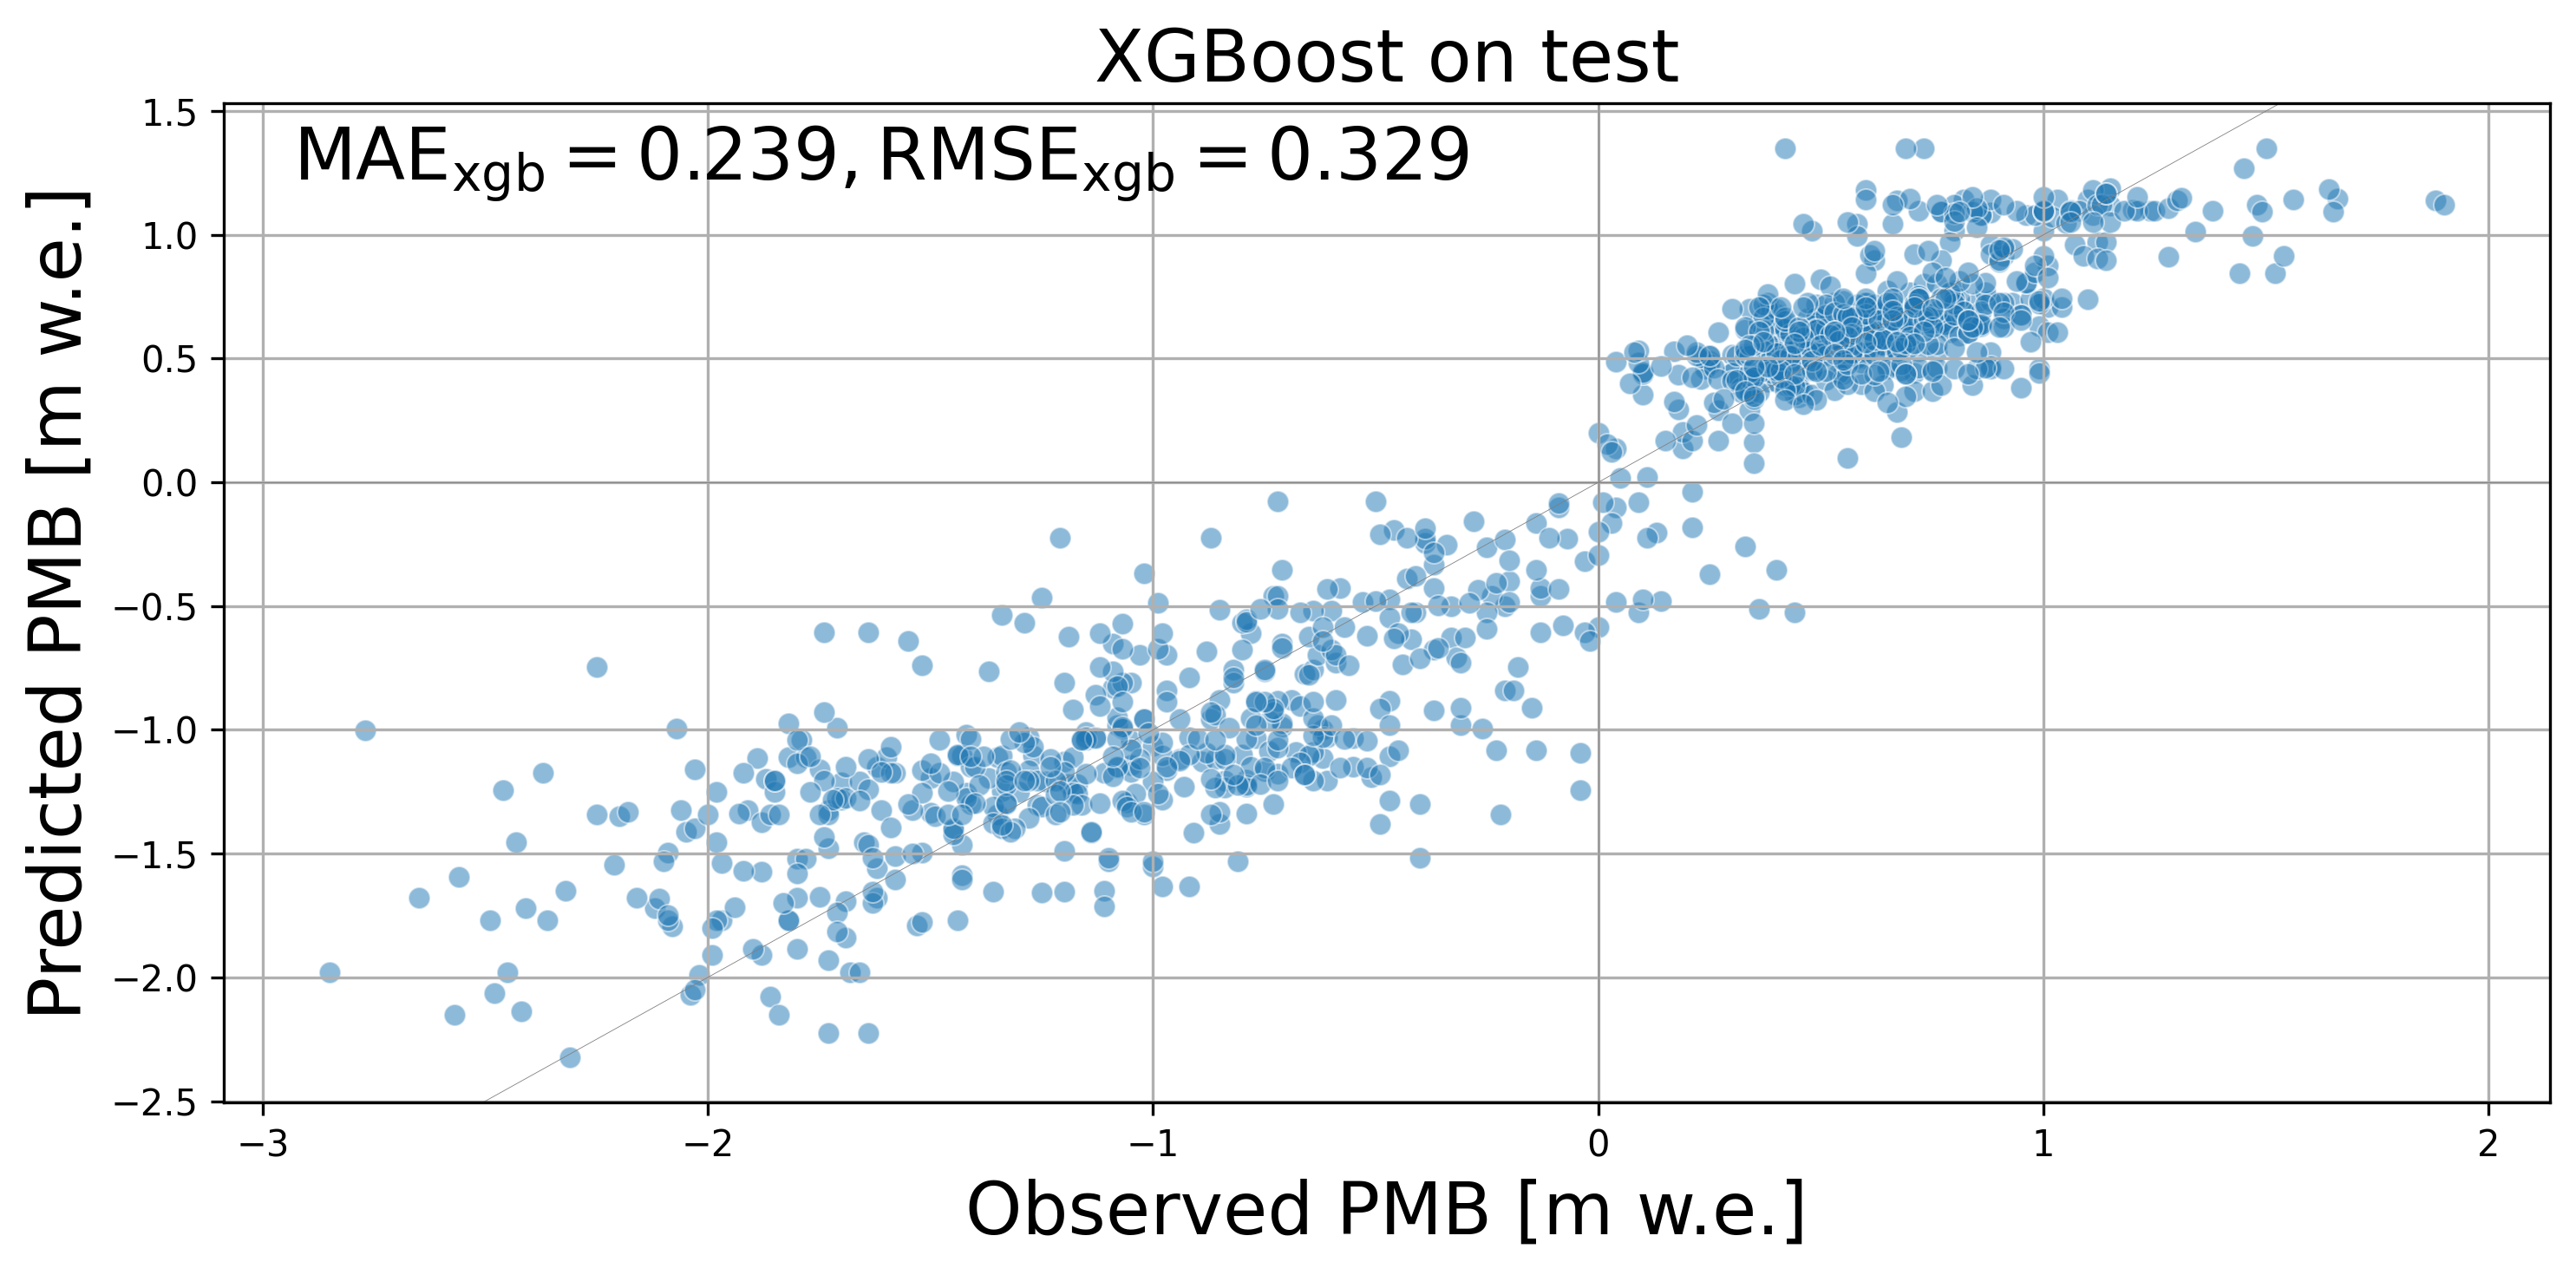

In [150]:
# Set to CPU for predictions:
xgb = best_estimator.set_params(device='cpu')

meta_data_columns = ["RGIId", "POINT_ID", "ID", "N_MONTHS", "MONTHS"]

# Make predictions on test
features_test, metadata_test = xgb._create_features_metadata(
    df_X_test, meta_data_columns)
y_pred = xgb.predict(features_test)

# Make predictions aggr to meas ID:
y_pred_agg = xgb.aggrPredict(metadata_test, meta_data_columns, features_test)

"""# Inverse scaling for scores and plotting
y_pred_agg=scaler.inverse_transform(y_pred_agg.reshape(-1, 1))
y_test=scaler.inverse_transform(y_test.reshape(-1, 1))"""

# Calculate scores
score = xgb.score(df_X_test, y_test)  # negative
mse, rmse, mae = xgb.evalMetrics(metadata_test, y_pred, y_test)

# Aggregate predictions to annual or winter:
df_pred = df_X_test.copy()
df_pred['target'] = y_test
grouped_ids = df_pred.groupby('ID').agg({'target': 'mean'})
grouped_ids['pred'] = y_pred_agg

predVSTruth(grouped_ids, mae, rmse, title='XGBoost on test')

In [151]:
import numpy as np
r2 = r2_score(grouped_ids['target'], grouped_ids['pred'])
rmse = np.sqrt(np.nanmean((grouped_ids['target']- grouped_ids['pred'])**2))


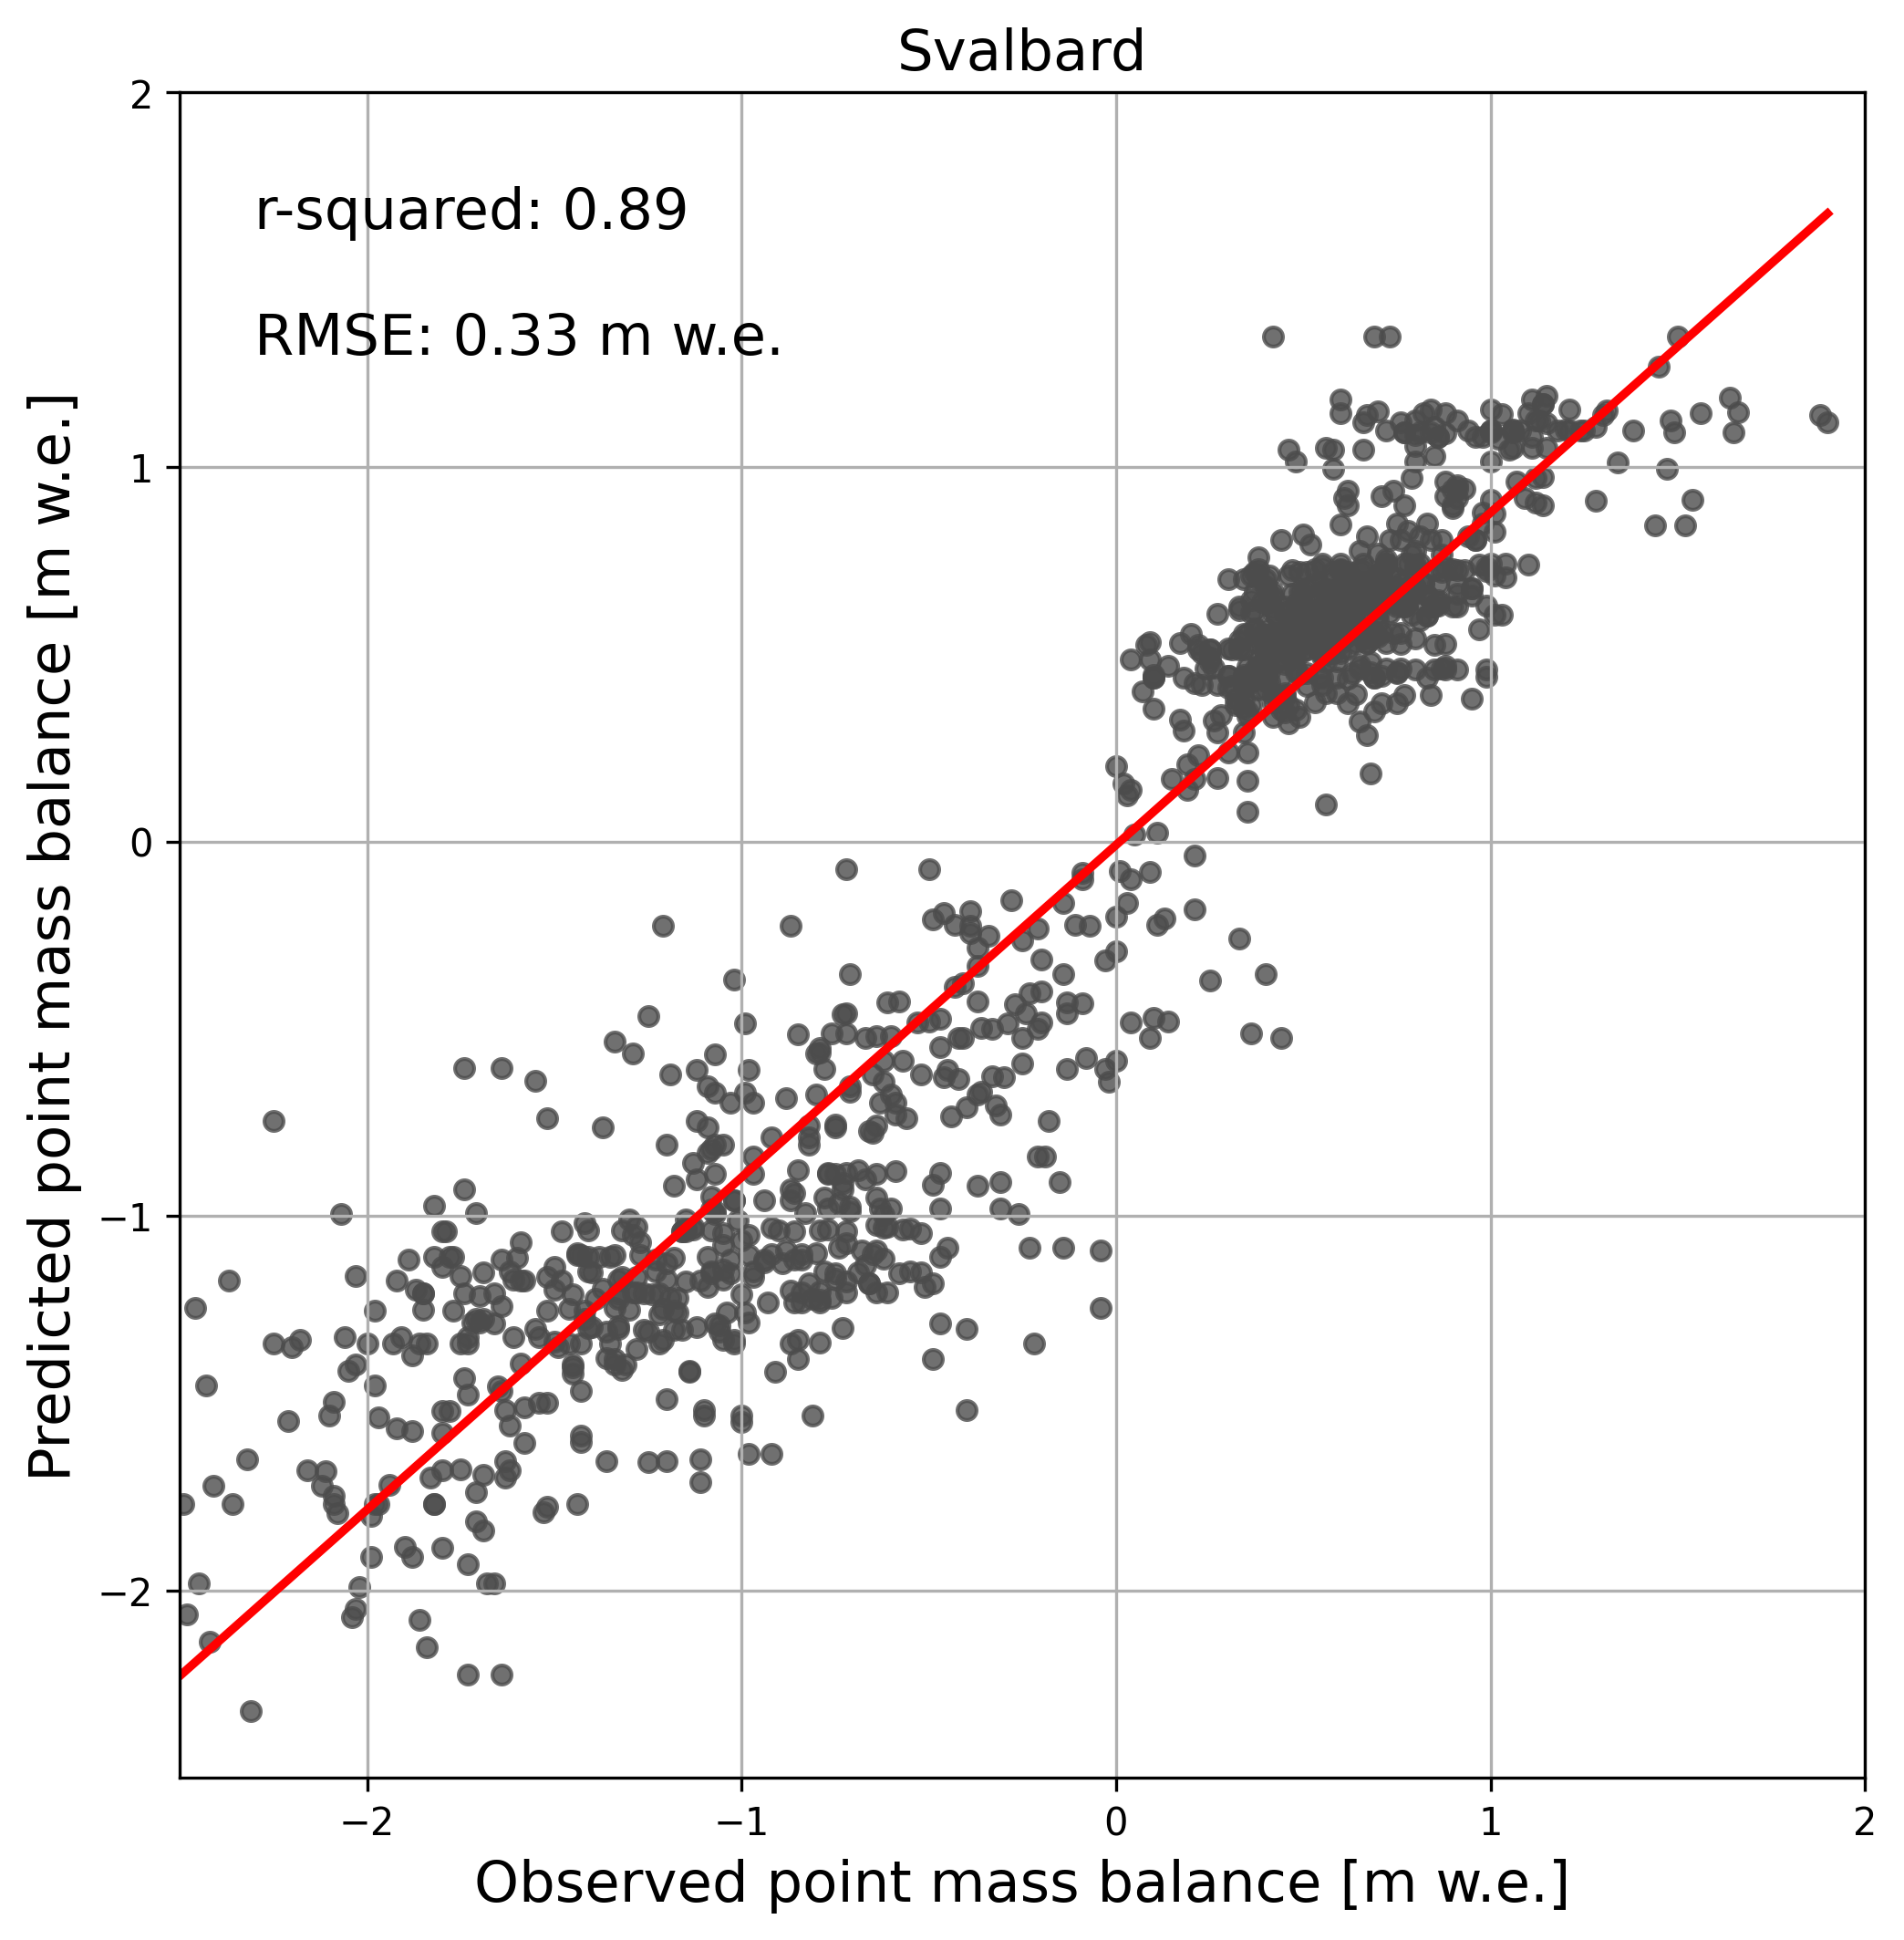

In [152]:
plt.rcParams['figure.dpi']=300
iniData = pd.read_csv('./example_data/svalbard/svalbard_topographical_features.csv')
grouped_ids["BALANCE_CODE"] = iniData["BALANCE_CODE"]

plt.figure(figsize=(8,8))

ax = sns.regplot(data=grouped_ids, x="target", y="pred",ci=None, marker="o", color=".3", line_kws=dict(color="r"))
#ax = sns.scatterplot(data=grouped_ids, x="target", y="pred",hue="BALANCE_CODE", color=".3")

handles, labels  =  ax.get_legend_handles_labels()
#ax.legend(handles, ['Summer', 'Winter'], loc='lower right')
ax.collections[0].set_sizes([25])                
ax.set(xlim=[-2.5, 2],ylim=[-2.5, 2], aspect=1, yticks=[-2, -1 ,0 ,1 ,2], xticks=[-2, -1 ,0 ,1 ,2])

ax.set_xlabel("Observed point mass balance [m w.e.]", fontsize=15)
ax.set_ylabel("Predicted point mass balance [m w.e.]", fontsize=15)
ax.set_title("Svalbard",fontsize=15)
plt.text(-2.3,1.3,"r-squared: "+str(np.round(r2,2)) + "\n \nRMSE: "+str(np.round(rmse,2))+" m w.e.",fontdict={'fontsize':15})
#plt.text(-2.3,6.3e10,"r-squared: "+str(np.round(r2,2)) + "\n \nRMSE: "+str(np.round(rmse,2))+" m w.e.",fontdict={'fontsize':15})

plt.grid() 


In [153]:
r2_BS = r2_score(grouped_ids.loc[grouped_ids["BALANCE_CODE"] == 'BS','target'], grouped_ids.loc[grouped_ids["BALANCE_CODE"] == 'BS','pred'])
rmse_BS = np.sqrt(np.nanmean((grouped_ids.loc[grouped_ids["BALANCE_CODE"] == 'BS','target']- grouped_ids.loc[grouped_ids["BALANCE_CODE"] == 'BS','pred'])**2))
r2_BW = r2_score(grouped_ids.loc[grouped_ids["BALANCE_CODE"] == 'BW','target'], grouped_ids.loc[grouped_ids["BALANCE_CODE"] == 'BW','pred'])
rmse_BW = np.sqrt(np.nanmean((grouped_ids.loc[grouped_ids["BALANCE_CODE"] == 'BW','target']- grouped_ids.loc[grouped_ids["BALANCE_CODE"] == 'BW','pred'])**2))

print('r2 summer: '+str(r2_BS))
print('rmse summer: '+str(rmse_BS))
print('r2 winter: '+str(r2_BW))
print('rmse winter: '+str(rmse_BW))

r2 = r2_score(grouped_ids['target'], grouped_ids['pred'])
print(r2)


r2 summer: 0.4886029003076484
rmse summer: 0.42060210068603326
r2 winter: 0.8963632506754037
rmse winter: 0.28035701110259204
0.8889167657306668
